In [2]:
!pip install kaggle

### Setup Kaggle Credentials:

1. Go to https://www.kaggle.com/
2. Sign in or create an account
3. Go to Account Settings (click your profile picture → Account)
4. Scroll to "API" section
5. Click "Create New API Token"
6. This downloads `kaggle.json` file
7. Upload it to this notebook or your environment

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

KeyboardInterrupt: 

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip -q chest-xray-pneumonia.zip -d ./dataset
print("✅ Dataset downloaded and extracted!")

### Method 2: Manual Download

If Kaggle API doesn't work:

1. Visit: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
2. Click "Download" button
3. Extract the zip file
4. Upload to your notebook environment

Dataset structure:
```
chest_xray/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── test/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── val/
    ├── NORMAL/
    └── PNEUMONIA/
```

In [4]:
!pip install numpy pandas opencv-python scikit-image PyWavelets Pillow matplotlib seaborn scikit-learn xgboost ipywidgets
print("✅ All packages installed!")

^C
✅ All packages installed!


---
## 📦 Step 2: Install Required Packages

In [5]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
import pywt

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output, HTML

import time
import pickle

print("✅ All libraries imported successfully!")

  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - --------------------

## 🔧 Step 4: Define Feature Extraction Functions

In [6]:
def get_rotation_invariant_glcm_features(image_array, distance=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=32):

    image_array = image_array.astype(np.uint8)
    max_val = image_array.max()
    if max_val >= levels:
        quantized_array = np.floor(image_array * ((levels - 1) / max_val)).astype(np.uint8)
    else:
        quantized_array = image_array

    gcom = graycomatrix(
        quantized_array,
        distances=distance,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    dissimilarity = np.mean(graycoprops(gcom, 'dissimilarity'))
    correlation = np.mean(graycoprops(gcom, 'correlation'))
    homogeneity = np.mean(graycoprops(gcom, 'homogeneity'))
    energy = np.mean(graycoprops(gcom, 'energy'))

    return [dissimilarity, correlation, homogeneity, energy]

In [8]:
def get_wavelet_features(image_array, wavelet='haar', level=1):
    coeffs = pywt.wavedec2(image_array.astype(float), wavelet, level=level)
    LH, HL, HH = coeffs[1]

    lh_energy = np.sum(LH**2)
    hl_energy = np.sum(HL**2)
    hh_energy = np.sum(HH**2)

    return [lh_energy, hl_energy, hh_energy]

In [9]:
def get_multi_feature_embedding(image_path, resize_to=(128, 128), n_blocks=4, bit_depth=16):
    if resize_to[0] % n_blocks != 0 or resize_to[1] % n_blocks != 0:
        raise ValueError("resize_to dimensions must be divisible by n_blocks.")

    block_w = resize_to[0] // n_blocks
    block_h = resize_to[1] // n_blocks

    try:
        img = Image.open(image_path).convert('L')
        img = img.resize(resize_to)
        img_array = np.array(img).astype(np.uint8)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(img_array)

        embedding = []
        MAX_DISSIMILARITY = 16.0
        MAX_INTENSITY = 255.0
        MAX_WAVELET_ENERGY = 500000.0

        for i in range(n_blocks):
            for j in range(n_blocks):
                block = clahe_img[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]

                glcm_features = get_rotation_invariant_glcm_features(block)
                wavelet_features = get_wavelet_features(block)
                mean_intensity = np.mean(block)
                std_intensity = np.std(block)

                features = [
                    min(glcm_features[0] / MAX_DISSIMILARITY, 1.0),
                    (glcm_features[1] + 1.0) / 2.0,
                    glcm_features[2],
                    glcm_features[3],
                    min(wavelet_features[0] / MAX_WAVELET_ENERGY, 1.0),
                    min(wavelet_features[1] / MAX_WAVELET_ENERGY, 1.0),
                    min(wavelet_features[2] / MAX_WAVELET_ENERGY, 1.0),
                    mean_intensity / MAX_INTENSITY,
                    std_intensity / MAX_INTENSITY
                ]

                for feat in features:
                    scaled_value = int(feat * (2**bit_depth - 1))
                    bin_str = bin(scaled_value)[2:].zfill(bit_depth)
                    bin_list = [int(bit) for bit in bin_str]
                    embedding.extend(bin_list)

        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [10]:
def embedding_to_analog(embedding, bit_depth=16):
    if not embedding:
        return []
    analog = []
    for i in range(0, len(embedding), bit_depth):
        bin_str = ''.join(str(bit) for bit in embedding[i:i+bit_depth])
        value = int(bin_str, 2)
        analog.append(value)
    return analog

In [11]:
def generate_em_wave(analog_values, feature_weights=None, carrier_freq=5,
                     sampling_rate=50, duration_per_value=0.1, max_value=2**16 - 1):
    if not analog_values:
        return np.array([0]), np.array([0])

    total_duration = len(analog_values) * duration_per_value
    t = np.linspace(0, total_duration, int(total_duration * sampling_rate), endpoint=False)
    wave = np.zeros_like(t)
    samples_per_value = int(duration_per_value * sampling_rate)

    if feature_weights is None:
        feature_weights = np.ones(len(analog_values))

    for i, value in enumerate(analog_values):
        amp = value / max_value
        weighted_amp = amp * feature_weights[i]

        start = i * samples_per_value
        end = min(start + samples_per_value, len(t))

        if start < len(t):
            wave[start:end] = weighted_amp * np.sin(2 * np.pi * carrier_freq * t[start:end])

    return t, wave

print("✅ Feature extraction functions defined!")

✅ Feature extraction functions defined!


---
## 📂 Step 5: Load Dataset

In [20]:
root_path = './dataset/chest_xray/train'
# Alternative paths you might need:
# root_path = './chest_xray/train'  # If extracted differently
# root_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'  # For Kaggle notebooks

image_paths = []
labels = []

print("Loading dataset...")
for label in os.listdir(root_path):
    label_path = os.path.join(root_path, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

print(f"✅ Loaded {len(df)} images")
print(f"\nDataset shape: {df.shape}")
print(f"\nClasses: {df['label'].unique()}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Loading dataset...
✅ Loaded 5216 images

Dataset shape: (5216, 2)

Classes: ['NORMAL' 'PNEUMONIA']

Class distribution:
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


## 📊 Step 6: Explore Data

In [21]:
print("First 5 samples:")
display(df.head())

print("\nDataset Info:")
print(df.info())

First 5 samples:


,image_path,label
0,./dataset/chest_xray/train\NORMAL\IM-0115-0001...,NORMAL
1,./dataset/chest_xray/train\NORMAL\IM-0117-0001...,NORMAL
2,./dataset/chest_xray/train\NORMAL\IM-0119-0001...,NORMAL
3,./dataset/chest_xray/train\NORMAL\IM-0122-0001...,NORMAL
4,./dataset/chest_xray/train\NORMAL\IM-0125-0001...,NORMAL



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5216 non-null   object
 1   label       5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB
None


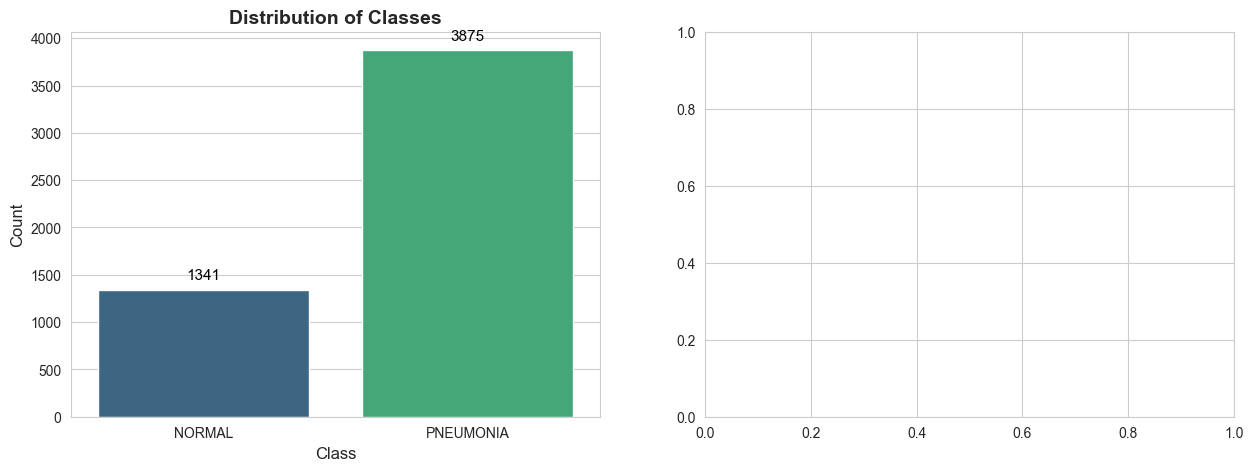

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=df, x="label", palette="viridis", ax=ax1)
ax1.set_title("Distribution of Classes", fontsize=14, fontweight='bold')
ax1.set_xlabel("Class", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')